In [ ]:
# September 2025
# Train multilingual classification neural network
# Violeta Berdejo-Espinola

# pytorch dataset
# pythorch model
# pytorch training loop

In [ ]:
%pip install torch sys matplotlib numpy

In [ ]:
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import sys

print('system version:', sys.version)
print('pytorch version:', torch.__version__)
print('numpy version:', np.version)

import platform; 

print(f'mac processor: {platform.mac_ver()}')
print(f'mps is available: {torch.backends.mps.is_built()}')
device = torch.device('mps')
print(f'device: {device}')

# datasets

In [ ]:
# define dataset function to ead all corpuses together

import pickle
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    
    """
    Args:
        x_paths (list[str]): List of pickle file paths for X (texts).
        y_paths (list[str]): List of pickle file paths for y (labels).
        transform (callable, optional): Function to apply to each text sample.
    """
    
    def __init__(self, x_paths, y_paths, transform=None):
        
        self.X, self.y = [], []

        # load and concatenate all pickles
        for x_data, y_data in zip(x_paths, y_paths):
            with open(x_data, "rb") as fx, open(y_data, "rb") as fy:
                X_part = pickle.load(fx)
                y_part = pickle.load(fy)

            # checking len of x and y is the same
            assert len(X_part) == len(y_part), f"length mismatch in {x_data} and {y_data}"

            # store corpus in X and y list
            self.X.extend(X_part)
            self.y.extend(y_part)

        # checking all corpuses are stored
        assert len(self.X) == len(self.y), "x and y have the same length"
        # self.transform = transform
        
    # number of instances in dataset
    def __len__(self):
        return len(self.X)

    # retrieve a single instance and its label at a given index
    def __getitem__(self, idx):
        text, label = self.X[idx], self.y[idx]

        # if self.transform:
        #     text = self.transform(text)

        return text, label

In [ ]:
# define dataset function

import pickle
import mpu
from torch.utils.data import Dataset

class TextDataset(Dataset):
    
    def __init__(self, texts, labels, sentence_model: SentenceTransformer):
        
        # load
        self.texts = mpu.io.read(texts)
        self.labels = mpu.io.read(labels)
        # self.texts = texts
        # self.labels = labels
        self.sentence_model = sentence_model
        
        # Pre-compute embeddings for efficiency
        print("Computing sentence embeddings...")
        self.embeddings = self.sentence_model.encode(texts)
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


In [ ]:


class ClassificationDataset(Dataset):
    
    """
    Args:
        x_paths (list[str]): List of pickle file paths for X (texts).
        y_paths (list[str]): List of pickle file paths for y (labels).
        transform (callable, optional): Function to apply to each text sample.
    """
    
    def __init__(self, x_paths, y_paths, transform=None):
        
        # load
        self.X = mpu.io.read(x_paths)
        self.y = mpu.io.read(y_paths)

        # checking X and y have the same length
        assert len(self.X) == len(self.y), "x and y have the same length"
        self.transform = transform
        
    # number of instances in dataset
    def __len__(self):
        return len(self.X)

    # retrieve a single instance and its label at a given index
    def __getitem__(self, idx):
        text, label = self.X[idx], self.y[idx]

        if self.transform:
            text = self.transform(text)

        return text, label

In [ ]:
# create datasets

filepaths_x = [
    "../data/for_analysis/eng_x.pickle",
    "../data/for_analysis/jap_x.pickle",
    "../data/for_analysis/spa_x.pickle"
]

filepaths_y = [
    "../data/for_analysis/eng_y.pickle",
    "../data/for_analysis/jap_y.pickle",
    "../data/for_analysis/spa_y.pickle"
]

eng_dataset = TextDataset(filepaths_x[0], filepaths_y[0], 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
# jap_dataset = ClassificationDataset(filepaths_x[1], filepaths_y[1])
# spa_dataset = ClassificationDataset(filepaths_x[2], filepaths_y[2])

print(len(eng_dataset), len(jap_dataset), len(spa_dataset))

In [ ]:
dat = spa_dataset[:2]
features, labels = dat
print(features, labels) # features

# split data

In [ ]:
from torch.utils.data import random_split

train_len = 5#int(len(spa_dataset) * 0.7)
val_len = 5545#int(len(spa_dataset) * 0.3)

training_dataset, test_dataset = random_split(spa_dataset, [train_len, val_len])

In [ ]:
print(f'Total dataset size: {len(spa_dataset)}')
print(f'Training dataset size: {len(training_dataset)}')
print(f'Validation dataset size: {len(test_dataset)}')

# dataloaders

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True) # normally, shuffle=True during training but not eval 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check load

for texts, labels in train_dataloader:
    print(texts[:3])
    print(labels[:3])
    break

In [ ]:
# if learning rate is too small:
# - model goes through many iteartions to converge
# - the loss does not change

In [ ]:
# training

torch.manual_seed(42)

import time
model.train()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
import pickle
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys

print('system version:', sys.version)
print('pytorch version:', torch.__version__)
print('numpy version:', np.version)

import platform; 

print(f'mac processor: {platform.mac_ver()}')
print(f'mps is available: {torch.backends.mps.is_built()}')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using device: {device}")

system version: 3.11.3 (v3.11.3:f3909b8bc8, Apr  4 2023, 20:12:10) [Clang 13.0.0 (clang-1300.0.29.30)]
pytorch version: 2.6.0
numpy version: <module 'numpy.version' from '/Users/uqvberde/Dropbox/translate/3.classifier_multiling/.venv/lib/python3.11/site-packages/numpy/version.py'>
mac processor: ('15.6.1', ('', '', ''), 'arm64')
mps is available: True
using device: mps


In [5]:
# file paths
filepaths_x = [
    # "../data/for_analysis/eng_x.pickle",
    # "../data/for_analysis/jap_x.pickle"
    "../data/for_analysis/spa_x.pickle"
]

filepaths_y = [
    # "../data/for_analysis/eng_y.pickle",
    # "../data/for_analysis/jap_y.pickle"
    "../data/for_analysis/spa_y.pickle"
]

In [3]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
)
hf_model = AutoModel.from_pretrained(
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
)
hf_model = hf_model.to(device)

# encode text
def encode_texts(texts, tokenizer, model, device, max_length=512):
    
    # tokenize
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    ).to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # mean pooling over token embeddings
    token_embeddings = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
    attention_mask = inputs["attention_mask"]

    # mean pooling
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    embeddings = sum_embeddings / sum_mask

    return embeddings  # (batch_size, hidden_size)

class TextDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, model, device, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        # Get embedding for single text
        embedding = encode_texts([text], self.tokenizer, self.model, self.device, self.max_length)
        embedding = embedding.squeeze(0)  # Remove batch dimension
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return embedding, label

class MLPClassifier(nn.Module):
    """Multi-layer perceptron for text classification"""
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], num_classes=2, dropout=0.3):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.classifier = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.classifier(x)

def load_data(filepaths_x, filepaths_y):
    """Load and combine multilingual data"""
    all_texts = []
    all_labels = []
    
    for fp_x, fp_y in zip(filepaths_x, filepaths_y):
        with open(fp_x, 'rb') as f:
            texts = pickle.load(f)
        with open(fp_y, 'rb') as f:
            labels = pickle.load(f)
            
        all_texts.extend(texts)
        all_labels.extend(labels)
    
    return all_texts, all_labels

def analyze_class_distribution(labels):
    """Analyze and visualize class distribution"""
    counter = Counter(labels)
    print("Class distribution:")
    for class_id, count in sorted(counter.items()):
        print(f"Class {class_id}: {count} samples ({count/len(labels)*100:.2f}%)")
    
    # Calculate imbalance ratio
    counts = list(counter.values())
    imbalance_ratio = max(counts) / min(counts)
    print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    return counter

def weighted_sampler(labels):  # Fixed function name
    """Create weighted sampler to handle class imbalance"""
    class_counts = Counter(labels)
    class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
    
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    return sampler

def compute_loss_weights(labels):
    """Compute class weights for weighted loss function"""
    unique_labels = np.unique(labels)
    class_weights = compute_class_weight(
        'balanced',
        classes=unique_labels,
        y=labels
    )
    
    return torch.FloatTensor(class_weights).to(device)

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for embeddings, labels in tqdm(dataloader, desc="Training"):
        embeddings, labels = embeddings.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for embeddings, labels in tqdm(dataloader, desc="Validation"):
            embeddings, labels = embeddings.to(device), labels.to(device)
            
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

Total documents: 5550
Class distribution:
Class 0: 5506 samples (99.21%)
Class 1: 44 samples (0.79%)
Imbalance ratio: 125.14:1
Train: 4440, Val: 555, Test: 555
Embedding dimension: 768
Model parameters: 560,002

Training...

Epoch 1/25


Training:   0%|          | 0/139 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


Train Loss: 0.0626, Train Acc: 81.64%
Val Loss: 0.6618, Val Acc: 71.35%
New best validation accuracy: 71.35%

Epoch 2/25


Validation: 100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Train Loss: 0.0093, Train Acc: 90.23%
Val Loss: 0.4305, Val Acc: 85.41%
New best validation accuracy: 85.41%

Epoch 3/25


Validation: 100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Train Loss: 0.0050, Train Acc: 94.39%
Val Loss: 0.3097, Val Acc: 94.41%
New best validation accuracy: 94.41%

Epoch 4/25


Validation: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Train Loss: 0.0041, Train Acc: 95.74%
Val Loss: 0.3701, Val Acc: 93.69%

Epoch 5/25


Validation: 100%|██████████| 18/18 [00:34<00:00,  1.94s/it]


Train Loss: 0.0032, Train Acc: 97.00%
Val Loss: 0.3456, Val Acc: 94.95%
New best validation accuracy: 94.95%

Epoch 6/25


Validation: 100%|██████████| 18/18 [00:34<00:00,  1.92s/it]


Train Loss: 0.0056, Train Acc: 95.05%
Val Loss: 0.4084, Val Acc: 89.19%

Epoch 7/25


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]


Train Loss: 0.0062, Train Acc: 93.13%
Val Loss: 0.4340, Val Acc: 91.89%

Epoch 8/25


Validation: 100%|██████████| 18/18 [00:34<00:00,  1.91s/it]


Train Loss: 0.0037, Train Acc: 95.59%
Val Loss: 0.4242, Val Acc: 94.95%

Epoch 9/25


Validation: 100%|██████████| 18/18 [00:33<00:00,  1.87s/it]


Train Loss: 0.0056, Train Acc: 95.29%
Val Loss: 0.5636, Val Acc: 85.23%

Epoch 10/25


Validation: 100%|██████████| 18/18 [00:34<00:00,  1.91s/it]


Train Loss: 0.0037, Train Acc: 95.79%
Val Loss: 0.6025, Val Acc: 92.97%

Epoch 11/25


Validation: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Train Loss: 0.0077, Train Acc: 93.20%
Val Loss: 0.4502, Val Acc: 89.01%

Epoch 12/25


Validation: 100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


Train Loss: 0.0035, Train Acc: 96.85%
Val Loss: 0.4819, Val Acc: 96.94%
New best validation accuracy: 96.94%

Epoch 13/25


Validation: 100%|██████████| 18/18 [00:31<00:00,  1.73s/it]


Train Loss: 0.0041, Train Acc: 95.77%
Val Loss: 0.4531, Val Acc: 94.77%

Epoch 14/25


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.81s/it]


Train Loss: 0.0020, Train Acc: 97.77%
Val Loss: 0.4807, Val Acc: 97.30%
New best validation accuracy: 97.30%

Epoch 15/25


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.78s/it]


Train Loss: 0.0023, Train Acc: 97.84%
Val Loss: 0.4316, Val Acc: 95.32%

Epoch 16/25


Validation: 100%|██████████| 18/18 [00:31<00:00,  1.77s/it]


Train Loss: 0.0037, Train Acc: 97.55%
Val Loss: 0.7052, Val Acc: 97.66%
New best validation accuracy: 97.66%

Epoch 17/25


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.82s/it]


Train Loss: 0.0057, Train Acc: 94.26%
Val Loss: 0.6645, Val Acc: 88.29%

Epoch 18/25


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.81s/it]


Train Loss: 0.0026, Train Acc: 97.14%
Val Loss: 0.5420, Val Acc: 96.04%

Epoch 19/25


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.79s/it]


Train Loss: 0.0058, Train Acc: 94.82%
Val Loss: 0.5293, Val Acc: 90.81%

Epoch 20/25


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.79s/it]


Train Loss: 0.0036, Train Acc: 96.49%
Val Loss: 0.5296, Val Acc: 93.15%

Epoch 21/25


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.80s/it]


Train Loss: 0.0022, Train Acc: 97.55%
Val Loss: 0.6235, Val Acc: 95.68%

Epoch 22/25


Validation: 100%|██████████| 18/18 [00:31<00:00,  1.76s/it]


Train Loss: 0.0014, Train Acc: 98.87%
Val Loss: 0.6725, Val Acc: 97.12%

Epoch 23/25


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.79s/it]


Train Loss: 0.0022, Train Acc: 98.47%
Val Loss: 0.6392, Val Acc: 94.95%

Epoch 24/25


Validation: 100%|██████████| 18/18 [00:31<00:00,  1.77s/it]


Train Loss: 0.0019, Train Acc: 98.27%
Val Loss: 0.5008, Val Acc: 95.50%

Epoch 25/25


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.80s/it]


Train Loss: 0.0019, Train Acc: 98.22%
Val Loss: 0.8189, Val Acc: 94.59%

Evaluating on test set...


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.78s/it]



Test Results:
Test Loss: 0.7210
Test Accuracy: 97.84%
Test Recall: 0.2500

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.99       551
     Class 1       0.10      0.25      0.14         4

    accuracy                           0.98       555
   macro avg       0.55      0.62      0.57       555
weighted avg       0.99      0.98      0.98       555


Confusion Matrix:
[[542   9]
 [  3   1]]


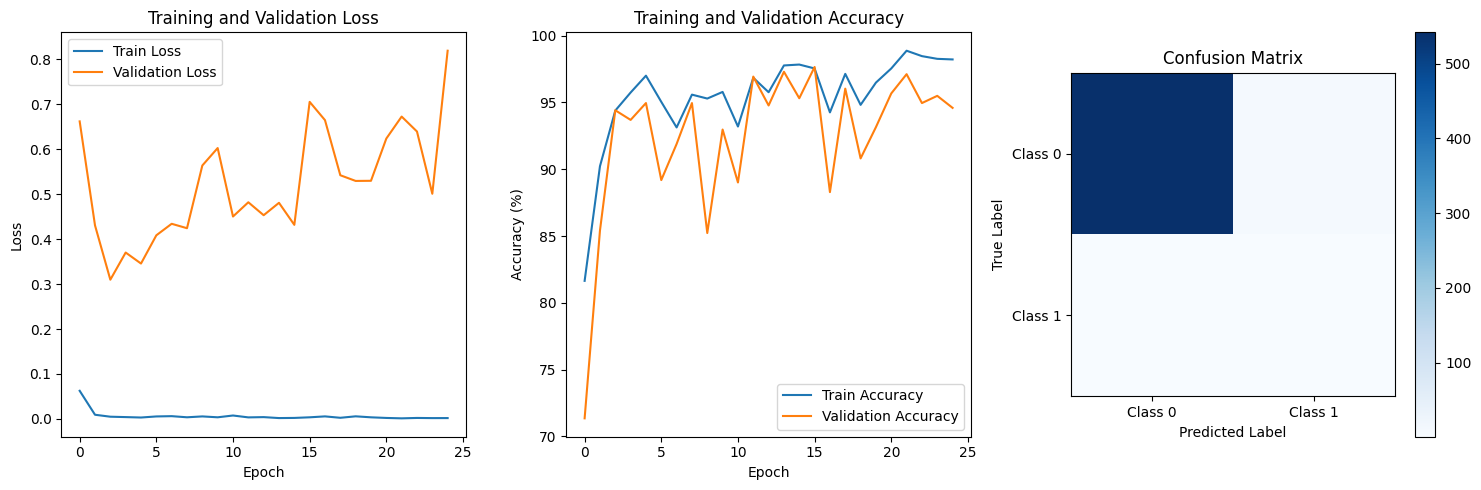

In [ ]:
# training loop

def main():
    
    texts, labels = load_data(filepaths_x, filepaths_y)
    
    print(f"Total documents: {len(texts)}")
    
    class_distribution = analyze_class_distribution(labels)
    
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # Create datasets
    train_dataset = TextDataset(X_train, y_train, tokenizer, hf_model, device)
    val_dataset = TextDataset(X_val, y_val, tokenizer, hf_model, device)
    test_dataset = TextDataset(X_test, y_test, tokenizer, hf_model, device)
    
    # Create weighted sampler for training data
    train_sampler = weighted_sampler(y_train)
    
    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler,
        num_workers=0  # 0 for MPS compatibility
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0
    )
    
    # Get embedding dimension
    sample_embedding, _ = train_dataset[0]
    embedding_dim = sample_embedding.shape[0]
    
    print(f"Embedding dimension: {embedding_dim}")
    
    # Initialize model
    model = MLPClassifier(
        input_dim=embedding_dim,
        hidden_dims=[512, 256, 128],
        num_classes=2,
        dropout=0.3  # fraction of neurons to drop during training at each training step
    ).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    num_epochs = 25
    best_val_acc = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Loss function and optimizer
    class_weights = compute_loss_weights(np.array(y_train))
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training loop
    print("\nTraining...")
    
    for epoch in range(num_epochs):
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step()  # Fixed - linear scheduler doesn't take val_loss
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best validation accuracy: {best_val_acc:.2f}%")
    
    # Load best model and test
    model.load_state_dict(torch.load('best_model.pth'))
    print("\nEvaluating on test set...")
    test_loss, test_acc, test_preds, test_labels = validate_epoch(
        model, test_loader, criterion, device
    )
    
    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Test Recall: {recall_score(test_labels, test_preds):.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, target_names=['Class 0', 'Class 1']))
    
    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot training curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # plt.subplot(1, 3, 3)
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.title('Confusion Matrix')
    # plt.colorbar()
    # tick_marks = np.arange(2)
    # plt.xticks(tick_marks, ['Class 0', 'Class 1'])
    # plt.yticks(tick_marks, ['Class 0', 'Class 1'])
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    return model, hf_model

torch.manual_seed(42)

if __name__ == "__main__": 
    model, hf_model = main()